In [19]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

In [20]:
import pandas as pd

nodes_df = pd.read_csv("fb-pages-food.nodes")  # has columns: id, name, new_id
edges_df = pd.read_csv("fb-pages-food.edges", header=None, names=["src", "dst"])

nodes_df.head(), edges_df.head()


(                id                     name  new_id
 0  402449106435352               Josh Marks     386
 1     368969274888  Blue Ribbon Restaurants     473
 2  765596333518863                Pat Neely       1
 3  136870209668885               La Griglia     542
 4  840078802741859              Jose Garces     189,
    src  dst
 0    0  276
 1    0   58
 2    0  132
 3    0  603
 4    0  398)

In [ ]:
URI = "neo4j://127.0.0.1:7687"    # change if needed
USER = "neo4j"
PASSWORD = "Your Password"  # change to your actual pwd

driver = GraphDatabase.driver(URI, auth=(USER, PASSWORD))

def run_cypher(query, params=None):
    with driver.session() as session:
        res = session.run(query, params or {})
        return [r.data() for r in res]

run_cypher("""
CREATE CONSTRAINT page_id_unique IF NOT EXISTS
FOR (p:Page)
REQUIRE p.id IS UNIQUE
""")



[]

In [22]:
def insert_nodes(tx, rows):
    tx.run("""
    UNWIND $rows AS row
    MERGE (p:Page {id: toInteger(row.new_id)})
    SET p.fb_id = row.id,
        p.name  = row.name
    """, rows=rows)

BATCH_SIZE = 1000

with driver.session() as session:
    for start in range(0, len(nodes_df), BATCH_SIZE):
        batch = nodes_df.iloc[start:start+BATCH_SIZE].to_dict("records")
        session.execute_write(insert_nodes, batch)
        print(f"Inserted nodes {start}–{start+len(batch)-1}")


Inserted nodes 0–619


In [23]:
def insert_edges(tx, rows):
    tx.run("""
    UNWIND $rows AS row
    MATCH (p1:Page {id: toInteger(row.src)})
    MATCH (p2:Page {id: toInteger(row.dst)})
    MERGE (p1)-[:LIKES]->(p2)
    MERGE (p2)-[:LIKES]->(p1)
    """, rows=rows)

with driver.session() as session:
    for start in range(0, len(edges_df), BATCH_SIZE):
        batch = edges_df.iloc[start:start+BATCH_SIZE].to_dict("records")
        session.execute_write(insert_edges, batch)
        print(f"Inserted edges {start}–{start+len(batch)-1}")


Inserted edges 0–999
Inserted edges 1000–1999
Inserted edges 2000–2101


In [24]:
run_cypher("MATCH (p:Page) RETURN count(p) AS num_pages")
run_cypher("MATCH ()-[r:LIKES]-() RETURN count(r) AS num_likes")


[{'num_likes': 8375}]

In [25]:
POS_LIMIT = 5000   # or tweak

training_query = f"""
CALL {{
    // Positive: existing edges
    MATCH (a:Page)-[:LIKES]-(b:Page)
    WHERE id(a) < id(b)
    WITH a,b
    LIMIT {POS_LIMIT}
    RETURN id(a) AS src, id(b) AS dst, 1 AS label

    UNION ALL

    // Negative: random non-edges
    MATCH (a:Page), (b:Page)
    WHERE id(a) < id(b)
      AND NOT (a)-[:LIKES]-(b)
    WITH a,b, rand() AS r
    ORDER BY r
    LIMIT {POS_LIMIT}
    RETURN id(a) AS src, id(b) AS dst, 0 AS label
}}
MATCH (srcNode) WHERE id(srcNode) = src
MATCH (dstNode) WHERE id(dstNode) = dst
RETURN
  src, dst, label,
  gds.alpha.linkprediction.commonNeighbors(srcNode, dstNode)        AS cn,
  gds.alpha.linkprediction.adamicAdar(srcNode, dstNode)             AS aa,
  gds.alpha.linkprediction.preferentialAttachment(srcNode, dstNode) AS pa
"""

train_data = run_cypher(training_query)
import numpy as np
df = pd.DataFrame(train_data).fillna(0)
df.head()


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=14, column=19, offset=276>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 276, 'line': 14, 'column': 19}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nCALL {\n    // Positive: existing edges\n    MATCH (a:Page)-[:LIKES]-(b:Page)\n    WHERE id(a) < id(b)\n    WITH a,b\n    LIMIT 5000\n    RETURN id(a) AS src, id(b) AS dst, 1 AS label\n\n    UNION ALL\n\n    // Negative: random non-edges\n    MATCH (a:Page), (b:Page)\n    WHERE id(a) < id(b)\n      AND NOT 

,src,dst,label,cn,aa,pa
0,620,787,1,4.0,1.274878,280.0
1,620,1013,1,1.0,0.333808,336.0
2,620,1058,1,2.0,0.627822,112.0
3,620,1077,1,2.0,0.660118,420.0
4,620,1103,1,0.0,0.000000,84.0


In [26]:
df = df.fillna(0)
df.describe()

,src,dst,label,cn,aa,pa
count,9182.000000,9182.000000,9182.000000,9182.000000,9182.000000,9182.000000
mean,826.410695,1035.202244,0.455456,2.036376,0.570058,778.647789
std,145.884339,144.140163,0.498039,3.903334,1.095477,1903.602408
min,620.000000,631.000000,0.000000,0.000000,0.000000,4.000000
25%,700.000000,930.000000,0.000000,0.000000,0.000000,40.000000
50%,805.000000,1061.000000,0.000000,0.000000,0.000000,160.000000
75%,928.750000,1157.000000,1.000000,3.000000,0.702439,600.000000
max,1228.000000,1239.000000,1.000000,47.000000,14.650504,29680.000000


In [27]:
feature_cols = ["cn", "aa", "pa"]
X = df[feature_cols].values
y = df["label"].values


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [29]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [30]:
y_proba = rf.predict_proba(X_test)[:, 1]   # probability for class 1
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f}")


ROC-AUC: 0.9211


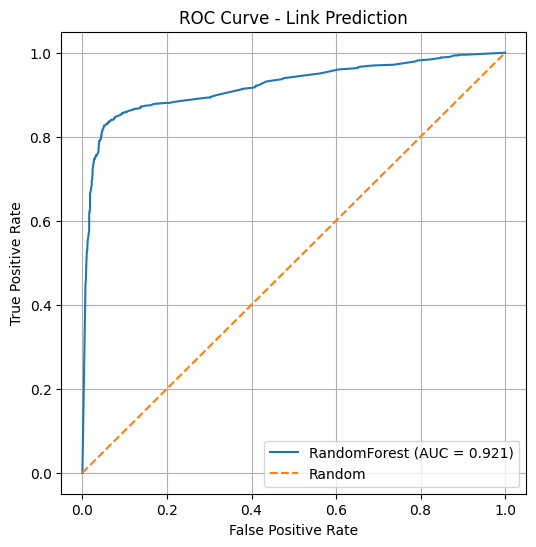

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"RandomForest (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Link Prediction")
plt.legend()
plt.grid(True)
plt.show()


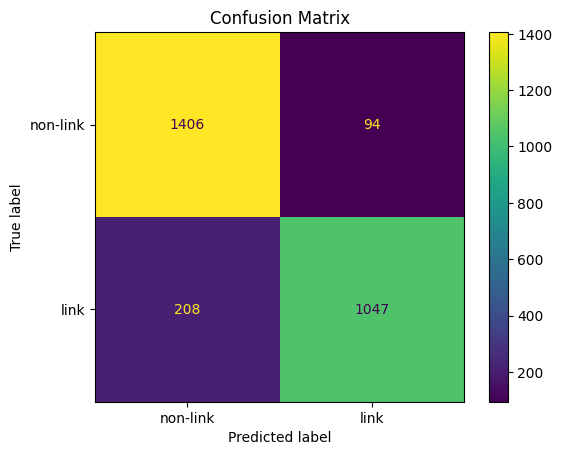

              precision    recall  f1-score   support

    non-link       0.87      0.94      0.90      1500
        link       0.92      0.83      0.87      1255

    accuracy                           0.89      2755
   macro avg       0.89      0.89      0.89      2755
weighted avg       0.89      0.89      0.89      2755



In [32]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-link", "link"]
)
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["non-link", "link"]))


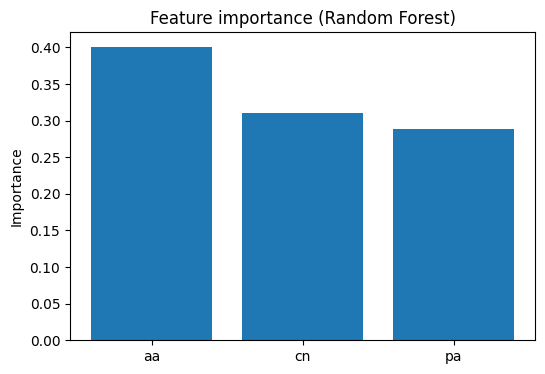

In [33]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), np.array(feature_cols)[indices])
plt.ylabel("Importance")
plt.title("Feature importance (Random Forest)")
plt.show()


In [34]:
CANDIDATE_LIMIT = 5000   # how many candidate non-edges to score

candidate_query = f"""
MATCH (a:Page), (b:Page)
WHERE id(a) < id(b)
  AND NOT (a)-[:LIKES]-(b)
WITH a,b, rand() AS r
ORDER BY r
LIMIT {CANDIDATE_LIMIT}
RETURN
  id(a) AS src,
  id(b) AS dst,
  gds.alpha.linkprediction.commonNeighbors(a, b)        AS cn,
  gds.alpha.linkprediction.adamicAdar(a, b)             AS aa,
  gds.alpha.linkprediction.preferentialAttachment(a, b) AS pa
"""

candidates = run_cypher(candidate_query)
cand_df = pd.DataFrame(candidates).fillna(0)
cand_df.head()


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=10, column=3, offset=142>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 142, 'line': 10, 'column': 3}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (a:Page), (b:Page)\nWHERE id(a) < id(b)\n  AND NOT (a)-[:LIKES]-(b)\nWITH a,b, rand() AS r\nORDER BY r\nLIMIT 5000\nRETURN\n  id(a) AS src,\n  id(b) AS dst,\n  gds.alpha.linkprediction.commonNeighbors(a, b)        AS cn,\n  gds.alpha.linkprediction.adamicAdar(a, b)             AS aa,\n  gds.alpha.linkpr

,src,dst,cn,aa,pa
0,1063,1110,0.0,0.000000,60.0
1,751,1031,1.0,0.209614,72.0
2,860,1090,0.0,0.000000,48.0
3,1115,1149,0.0,0.000000,48.0
4,701,1071,0.0,0.000000,12.0


In [35]:
X_cand = cand_df[feature_cols].values
cand_df["score"] = rf.predict_proba(X_cand)[:, 1]
cand_df.sort_values("score", ascending=False, inplace=True)
top_preds = cand_df.head(50).copy()
top_preds.head()


,src,dst,cn,aa,pa,score
2009,885,1084,6.0,2.090368,320.0,1.0
4616,836,957,8.0,2.011066,1160.0,1.0
1959,768,820,1.0,0.179220,616.0,1.0
434,820,886,1.0,0.179220,616.0,1.0
2557,671,774,11.0,2.796024,1232.0,1.0


In [36]:
# Fetch mapping of internal node id -> (page_id, name)
node_info = run_cypher("""
MATCH (p:Page)
RETURN id(p) AS internal_id, p.id AS page_id, p.name AS name
""")
node_df = pd.DataFrame(node_info)

id_to_name = dict(zip(node_df["internal_id"], node_df["name"]))

top_preds["src_name"] = top_preds["src"].map(id_to_name)
top_preds["dst_name"] = top_preds["dst"].map(id_to_name)

top_preds[["src_name", "dst_name", "score"]].head(10)


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=3, column=8, offset=23>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 23, 'line': 3, 'column': 8}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (p:Page)\nRETURN id(p) AS internal_id, p.id AS page_id, p.name AS name\n'


,src_name,dst_name,score
2009,Cuoco Filippo La Mantia,Alessandro Borghese,1.0
4616,Donatella Arpaia,Chef Elizabeth Falkner,1.0
1959,Leslie Gilliams,Chef David Burke,1.0
434,Chef David Burke,Colin Fassnidge,1.0
2557,Chef Mark Garcia,Chef Richard Sandoval,1.0
4895,Harlem EatUp,Chef Kent Graham,1.0
3998,Zac Kara,Alex Guarnaschelli,1.0
4155,Geoffrey Zakarian,Chef Billy Parisi,1.0
2496,Marcus Samuelsson,Chef Billy Parisi,1.0
3477,Chef Kent Graham,Logan Junior Chef,1.0


In [40]:
# Pick the node that appears most often in top predictions
src_counts = top_preds["src"].value_counts()
focal_internal_id = src_counts.index[0]
focal_internal_id
focal_name = id_to_name[focal_internal_id]
print("Focal page:", focal_name)


Focal page: Donatella Arpaia


In [41]:
ego_query = """
MATCH (p:Page)-[:LIKES]-(nbr:Page)
WHERE id(p) = $focal_id
RETURN id(p) AS src, id(nbr) AS nbr
"""
ego_data = run_cypher(ego_query, {"focal_id": focal_internal_id})
ego_df = pd.DataFrame(ego_data)
ego_df.head()


Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=3, column=7, offset=42>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 42, 'line': 3, 'column': 7}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: '\nMATCH (p:Page)-[:LIKES]-(nbr:Page)\nWHERE id(p) = $focal_id\nRETURN id(p) AS src, id(nbr) AS nbr\n'
Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an applica

,src,nbr
0,836,649
1,836,676
2,836,788
3,836,826
4,836,844


In [42]:
G = nx.Graph()

# Add focal node
G.add_node(focal_internal_id, label=id_to_name.get(focal_internal_id, "focal"))

# Add existing neighbors
for _, row in ego_df.iterrows():
    nbr_id = row["nbr"]
    G.add_node(nbr_id, label=id_to_name.get(nbr_id, str(nbr_id)))
    G.add_edge(focal_internal_id, nbr_id, type="existing")

# Add predicted neighbors (top N)
TOP_K_VIS = 10
focal_preds = top_preds[top_preds["src"] == focal_internal_id].head(TOP_K_VIS)

for _, row in focal_preds.iterrows():
    dst_id = row["dst"]
    score = row["score"]
    G.add_node(dst_id, label=id_to_name.get(dst_id, str(dst_id)))
    # If it's already an existing edge, skip so we don't duplicate
    if not G.has_edge(focal_internal_id, dst_id):
        G.add_edge(focal_internal_id, dst_id, type="predicted", score=score)


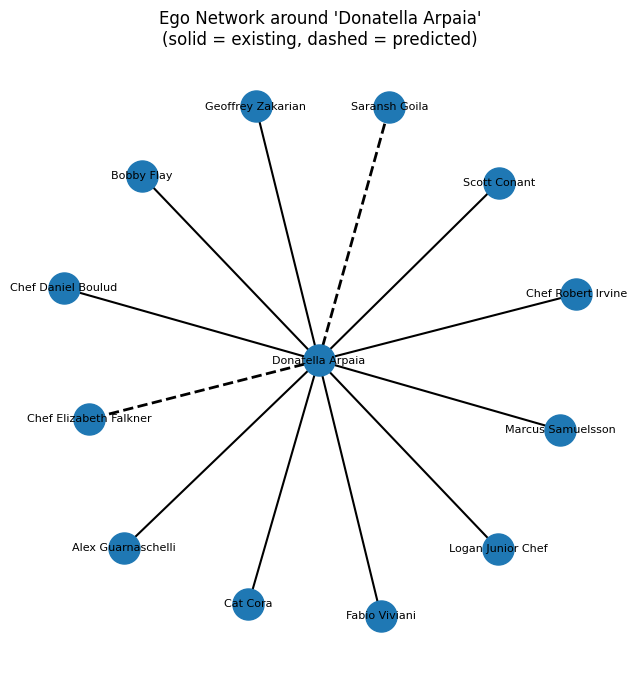

In [43]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 8))

# Separate existing and predicted edges
existing_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("type") == "existing"]
pred_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("type") == "predicted"]

# Nodes
nx.draw_networkx_nodes(G, pos, node_size=500)

# Existing edges
nx.draw_networkx_edges(G, pos, edgelist=existing_edges, width=1.5)

# Predicted edges – different style
nx.draw_networkx_edges(G, pos, edgelist=pred_edges, width=2.0, style="dashed")

# Labels
labels = {n: d.get("label", str(n)) for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title(f"Ego Network around '{focal_name}'\n(solid = existing, dashed = predicted)")
plt.axis("off")
plt.show()
